<h4>Here is the continuation of exercise2 using some quite amazing tools detecting noise management. Tools such as MAD and Ransac
</h4>

In [7]:
import pandas as pd
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.float_format', '{:.1f}'.format)

# load the data and remove the usual unusable columns in this data
df = pd.read_csv("white_wine_cleaned.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.3,0.4,20.7,0.0,45.0,170.0,1.0,3.0,0.5,8.8,6
1,6.3,0.3,0.3,1.6,0.0,14.0,132.0,1.0,3.3,0.5,9.5,6
2,8.1,0.3,0.4,6.9,0.1,30.0,97.0,1.0,3.3,0.4,10.1,6
3,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
4,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.2,0.3,1.6,0.0,24.0,92.0,1.0,3.3,0.5,11.2,6
4894,6.6,0.3,0.4,8.0,0.0,57.0,168.0,1.0,3.1,0.5,9.6,5
4895,6.5,0.2,0.2,1.2,0.0,30.0,111.0,1.0,3.0,0.5,9.4,6
4896,5.5,0.3,0.3,1.1,0.0,20.0,110.0,1.0,3.3,0.4,12.8,7


In [3]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [4]:
# since RANSAC is a regression algorithm, X/y -split
# X contains all features (variables) except the target variable 'quality'
# while y is the target variable 'quality' to be predicted.
X = df.drop("quality", axis=1)
y = df['quality']

# I initalize RANSAC regerssor to fit into the data
# the RANSACRegressor algorithm fits model iteratively, 
# Essentially minimizing the influence of outliers by using only a subset of inliers.
# RANSAC needs a threshold in order to process data
# as it determines the maximum residual (difference between the predicted and actual value) 
# for a point that is importantly to be considered an inlier.
# I choose the value 1.5 for the residual_threshold
# it is because its commonly used multiplier 
# when defining thresholds based on the standard deviation as well as IGR 
ransac = RANSACRegressor(residual_threshold=np.std(y) * 1.5)
ransac.fit(X, y)

# then splitting the result into 
# inliers and outliers
# inliers is the good data, according to the distribution 
# outliers are far away from the main distribution
# Therefore, meaning get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

Inliers: 3772
Outliers: 1126


<h4>Above Inliers 3772 data points in the dataset which I think fit well with the model and also can be considered as part of the main distribution. Subsequently, the points have residuals -differences between predicted and actual values within the specified threshold of 1.5 * np.std(y).
Therefore with these inliers, the RANSAC perhaps will try to build a model that captures the typical data pattern without being skewed by unusual or extreme values. Essentially, I think it will make the dataset distribution normal</h4>
<h4>I would say there is relatively large number of outliers (1126 out of a total of 4898 data points, about 23%) which suggested that the dataset contains a fair amount of noise or extreme values in the quality variable.</h4>

In [5]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

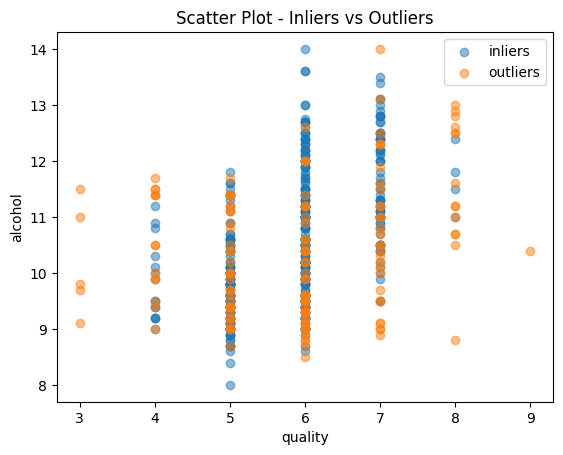

In [8]:
# Now plotting the graph for visualization

variable = "quality"
target = "alcohol"

# For the sample size
# I choose to sample 400 inliers and 
# 150 outliers for the balancing detail
# purpose is clarity too
# From research large samples can clutter the plot 
# and same time smaller sample size 
# might affect the representation of the features
# distributions ineffective.
# I stick to Tuomas advice below
# if you want to reduce the number of points visualized
# sample a small amount of points, for example 300-500
inliers_sample = inliers.sample(400)
outliers_sample = outliers.sample(150)

plt.scatter(inliers_sample[variable], inliers_sample[target], label="inliers", alpha=0.5)
plt.scatter(outliers_sample[variable], outliers_sample[target], label="outliers", alpha=0.5)

plt.xlabel(variable)
plt.ylabel(target)

plt.title("Scatter Plot - Inliers vs Outliers")
plt.legend()
plt.show()

<Axes: xlabel='quality', ylabel='Count'>

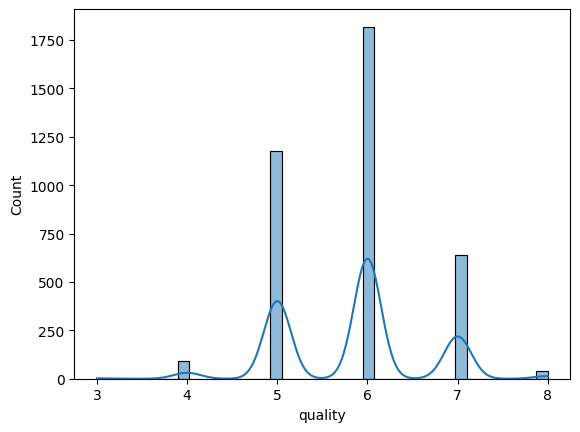

In [10]:
sns.histplot(data=inliers, x="quality", kde=True)

<h4>The distribution is pretty quite balance though quality 7 tends to skewed to left otherwise the RANSAC kind of amazing tool</h4>

In [1]:
# Noise management
# I intend to use MAD for noise detection
import numpy as np
import pandas as pd

df = pd.read_csv("white_wine_cleaned.csv")

variable = "quality"

# Calculate the median
median = df[variable].median()

# Calculate MAD
mad = np.median(np.abs(df[variable] - median))

# Define a threshold for noise detection
threshold = 2 * mad

# Detect noise
noise = df[np.abs(df[variable] - median) > threshold]

print("Detected noise using MAD:")
noise

Detected noise using MAD:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
251,8.5,0.260,0.21,16.20,0.074,41.0,197.0,0.99800,3.02,0.50,9.8,3
253,5.8,0.240,0.44,3.50,0.029,5.0,109.0,0.99130,3.53,0.43,11.7,3
294,9.1,0.590,0.38,1.60,0.066,34.0,182.0,0.99680,3.23,0.38,8.5,3
445,7.1,0.320,0.32,11.00,0.038,16.0,66.0,0.99370,3.24,0.40,11.5,3
740,6.9,0.390,0.40,4.60,0.022,5.0,19.0,0.99150,3.31,0.37,12.6,3
774,9.1,0.270,0.45,10.60,0.035,28.0,124.0,0.99700,3.20,0.46,10.4,9
820,6.6,0.360,0.29,1.60,0.021,24.0,85.0,0.98965,3.41,0.61,12.4,9
827,7.4,0.240,0.36,2.00,0.031,27.0,139.0,0.99055,3.28,0.48,12.5,9
873,10.3,0.170,0.47,1.40,0.037,5.0,33.0,0.99390,2.89,0.28,9.6,3
876,6.9,0.360,0.34,4.20,0.018,57.0,119.0,0.98980,3.28,0.36,12.7,9


<h4>Based on the tool Median Absolute Deviation (MAD) used to manage Noise detection in the white wine dataset. Using the variable 'quality', so any value in quality that deviates from the median by more than twice the MAD is flagged as noise. And the tool MAD helps noise to detect variables that values are identified by their distance from the central quality value (median) relative to MAD.</h4>
<h4>And it can be seen that the dataset has noise in almost all the variables. The detected noise values are generally due to their extreme values in the dataset, especially in quality, and high/low values in 'sulphates', 'chlorides', 'free sulfur dioxide', and 'total sulfur dioxide'. The presence of these extreme values deviates significantly from the median (MAD) pattern, which I think the reason the variables are flagged.</h4>

<h4>I also think outliers can cause model to "overfit" because of the unusual values, which means that the model might learn certain  patterns that is specific to those noisy values rather than the generalization trends. I think this could lead to poor performance on unseen data, especially if the model places undue 
emphasis on the features with outliers.</h4>

<h4>Considering the skewed model interpretations which I do think noise in the features (variables) can alter the interpretation of the feature importance. Such as, say if 'quality' is affected by noise in chlorides or sulphates, it is possible for the model to mistakenly interpret those features as more influential than they actually are, leading to flawed conclusions about what characteristics truly impact the white wine quality.</h4>

In [ ]:
# Using ransac tool to manage (detect) the noise 
